In [38]:
import pandas as pd
import numpy as np
import os
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from itertools import islice

import statsmodels.api as sm
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_test = pd.read_csv("../BigdataProject/df_test_fixed.csv") 

In [3]:
# To limit the numbers of rows of pandas df output
pd.options.display.max_rows = 20

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826 entries, 0 to 3825
Data columns (total 6 columns):
Unnamed: 0     3826 non-null int64
sessionID      3826 non-null object
timestamp      3825 non-null object
type           3826 non-null object
totalTests     3826 non-null float64
testsPassed    3826 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 179.5+ KB


In [5]:
# convert the timestamp column from object datatype to datetime
df_test["timestamp"] = pd.to_datetime(df_test.timestamp)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826 entries, 0 to 3825
Data columns (total 6 columns):
Unnamed: 0     3826 non-null int64
sessionID      3826 non-null object
timestamp      3825 non-null datetime64[ns]
type           3826 non-null object
totalTests     3826 non-null float64
testsPassed    3826 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 179.5+ KB


In [6]:
len(df_test)

3826

In [7]:
df_test.head()

,Unnamed: 0,sessionID,timestamp,type,totalTests,testsPassed
0,4,115,2016-07-13 20:24:46,test,21.0,21.0
1,5,143,2016-12-16 15:32:02,test,4.0,0.0
2,6,157,2016-07-13 17:44:58,test,1.0,0.0
3,7,158,2016-07-13 18:43:38,test,0.0,0.0
4,8,158,2016-07-13 18:45:11,test,0.0,0.0


In [8]:
# select columns from index 1 till the end.Then rename dataframe
df_test = df_test.iloc[:,1:]
df_test.head()

,sessionID,timestamp,type,totalTests,testsPassed
0,115,2016-07-13 20:24:46,test,21.0,21.0
1,143,2016-12-16 15:32:02,test,4.0,0.0
2,157,2016-07-13 17:44:58,test,1.0,0.0
3,158,2016-07-13 18:43:38,test,0.0,0.0
4,158,2016-07-13 18:45:11,test,0.0,0.0


In [9]:
# get basic information about the parameters of the data
df_test.describe(include = "all")

,sessionID,timestamp,type,totalTests,testsPassed
count,3826,3825,3826,3826.000000,3826.000000
unique,762,3825,1,NaN,NaN
top,c247d420-c522-4ab1-bb96-b1d18aa8a5a2,2016-07-22 12:10:13,test,NaN,NaN
freq,39,1,3826,NaN,NaN
first,NaN,2016-04-17 11:13:03,NaN,NaN,NaN
last,NaN,2017-02-09 11:05:57,NaN,NaN,NaN
mean,NaN,NaN,NaN,88.780972,76.577627
std,NaN,NaN,NaN,430.785770,392.217908
min,NaN,NaN,NaN,-1.000000,-1.000000
25%,NaN,NaN,NaN,1.000000,0.000000


In [10]:
# Are there instances where totalTests is less than Testspassed?expected answer should be none
instance = len(df_test.loc[df_test.totalTests < df_test.testsPassed])
print("There are {0} instance(s) ".format(instance))

There are 0 instance(s) 


In [11]:
# it doesnt make sense to have negative totalTest or testsPassed, right?
df_test.loc[((df_test.totalTests < 0 ) | (df_test.testsPassed < 0)),:]


,sessionID,timestamp,type,totalTests,testsPassed
3819,f5decb96-f8e5-4f,NaT,test,-1.0,-1.0


In [12]:
# discovery one, found out an entry has a missing values, let find out if we have more in this dataset
df_test.isnull().sum()

sessionID      0
timestamp      1
type           0
totalTests     0
testsPassed    0
dtype: int64

In [13]:
# It seems like only the timestamp column a missing value, let remove Nan values from the data
df_test = df_test.dropna()

# to crosscheck if we have any missing value
print(df_test.isnull().values.any())
print(df_test.isnull().sum())

False
sessionID      0
timestamp      0
type           0
totalTests     0
testsPassed    0
dtype: int64


In [14]:
# number of events where totalTests same as testsPassed
is_total = len(df_test.loc[df_test.totalTests == df_test.testsPassed])
print("Number of totalTests same as testsPassed: {0}".format(is_total))

Number of totalTests same as testsPassed: 1414


In [15]:
# number of events where totalTests same as testsPassed
not_total = len(df_test.loc[df_test.totalTests > df_test.testsPassed])
print("Number of totalTests same as testsPassed: {0}".format(not_total))

Number of totalTests same as testsPassed: 2411


In [16]:
%matplotlib inline

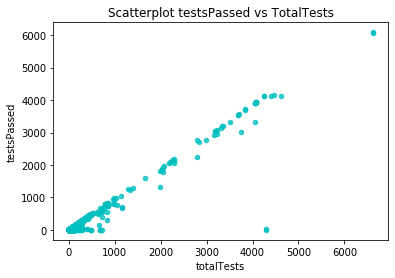

In [17]:
#finding pattern
df_test.plot.scatter(x = "totalTests",
                     y = "testsPassed",
                     color="c",
                     title = "Scatterplot testsPassed vs TotalTests",
                     alpha = 0.8);

NOTES ABOUT THIS SCATTERPLOT:
<br>The scatter plot above shows most tests events are between the 0-1800
<br>Also, their is an upwards trend with a between testpassed and totaltests, Presence of Positive correlation!
<br> And, a few outliers

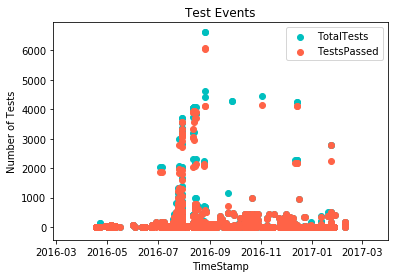

In [18]:
plt.scatter(df_test.timestamp,df_test.totalTests, color="c", label = "TotalTests")
plt.scatter(df_test.timestamp, df_test.testsPassed, color ="tomato", label = "TestsPassed")
plt.xlabel("TimeStamp");
plt.ylabel("Number of Tests");
plt.title("Test Events")
plt.legend();

NOTES ABOUT THIS SCATTERPLOT:
<br> This is clear that there is no correlation between the tests event and time
<br> We can also infer that, as the number of test events increases, the chances of fully completing the tests reduces, which is logical.

<h3> Analysis Phase: 
<h5> Question: linking time since last tests run to probability of tests passing

In [19]:
# first, we create a new column that will of the probability of testspassed
df_test["prob_testsPassed"] = ((df_test.testsPassed/df_test.totalTests) * 100)
df_test.head(5)

,sessionID,timestamp,type,totalTests,testsPassed,prob_testsPassed
0,115,2016-07-13 20:24:46,test,21.0,21.0,100.0
1,143,2016-12-16 15:32:02,test,4.0,0.0,0.0
2,157,2016-07-13 17:44:58,test,1.0,0.0,0.0
3,158,2016-07-13 18:43:38,test,0.0,0.0,NaN
4,158,2016-07-13 18:45:11,test,0.0,0.0,NaN


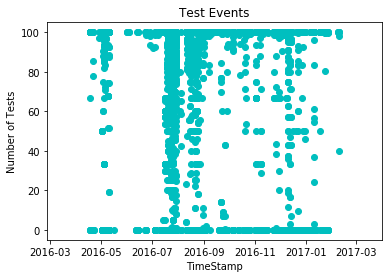

In [20]:
plt.scatter(df_test.timestamp,df_test.prob_testsPassed, color="c")
plt.xlabel("TimeStamp");
plt.ylabel("Number of Tests");
plt.title("Test Events")
plt.show()

In [21]:
# replace entries with nan that occurred when calculating the probability of tests passed (0/0) * 100. 
# Question: Maybe i need to drop them??
df_test.prob_testsPassed.fillna(0, inplace=True)

In [22]:
df_test.isnull().sum()

sessionID           0
timestamp           0
type                0
totalTests          0
testsPassed         0
prob_testsPassed    0
dtype: int64

In [23]:
# create a unique sessionId data set
dat = df_test.groupby(["sessionID"]).agg({"timestamp": np.min})
dat.head(10)

,timestamp
sessionID,
006eb9aa-33f1-4e9e-8e74-7c978b58ee4a,2016-05-03 09:32:16
03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:21:18
06ed56fc-0467-4b01-8c7b-f2ffe300ff0e,2016-08-19 11:08:25
06f9c3b5-9ba5-44b5-a95a-6b9d280343ff,2016-12-21 13:13:27
083c67aa-3e7d-4d78-8286-e28a85d6e1cc,2016-05-09 11:54:08
0abd4866-4f13-4779-b14f-5dcb5b16c319,2016-12-26 17:39:41
0d11f58a-c185-472b-b6c6-46b9d651d1e4,2016-05-02 22:55:46
0d868b35-78ad-46c2-bdfe-d1e26aad7d16,2016-05-10 18:39:37
0e74b63e-a342-44f7-a1c3-0f7843c6d837,2016-09-23 15:29:08


In [24]:
#convert to dictionary format
dat = dat.to_dict()

In [25]:
startwith = {'sessionID': 'nonexistent-atsirtsakitaiea'}
time_btw_tests = []
for x,y in df_test.iterrows():
    if startwith["sessionID"] == y["sessionID"]:
        begin = startwith["timestamp"]
    else:
        begin = dat["timestamp"][y["sessionID"]]
    end = y["timestamp"]
    duration = (end - begin).seconds
    time_btw_tests.append((duration, y["prob_testsPassed"]))
    startwith = y
time_btw_tests

[(0, 100.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (93, 0.0),
 (4, 0.0),
 (15, 0.0),
 (89, 0.0),
 (91, 0.0),
 (58, 4.761904761904762),
 (145, 100.0),
 (71, 100.0),
 (16, 100.0),
 (7, 100.0),
 (28, 100.0),
 (59, 100.0),
 (56, 100.0),
 (85, 100.0),
 (298, 100.0),
 (75, 100.0),
 (0, 0.0),
 (73, 0.0),
 (0, 100.0),
 (29, 100.0),
 (26, 0.0),
 (110, 100.0),
 (57, 100.0),
 (212, 0.0),
 (92, 0.0),
 (74, 0.0),
 (49, 0.0),
 (69, 100.0),
 (37, 100.0),
 (0, 67.74193548387096),
 (0, 67.74193548387096),
 (0, 99.63768115942028),
 (0, 66.66666666666666),
 (0, 99.65034965034964),
 (0, 0.0),
 (206, 98.38709677419355),
 (91, 0.0),
 (100, 0.0),
 (135, 91.25827814569536),
 (98, 96.30497007546188),
 (196, 100.0),
 (16, 99.7229916897507),
 (72, 55.55555555555556),
 (27, 84.61538461538461),
 (181, 90.3448275862069),
 (0, 99.77168949771689),
 (0, 0.0),
 (96, 66.66666666666666),
 (373, 0.0),
 (0, 100.0),
 (0, 0.0),
 (158, 0.0),
 (96, 0.0),
 (271, 0.0),
 (696, 0.0),
 (43, 0.0),
 (65, 0.0),
 (343, 100.0),
 (63, 100.0)

In [27]:
#convert to dataframe
df_new = pd.DataFrame(data=time_btw_tests, columns=["time_in_sec","prob_testsPassed"])


# Visualizing and Exploring the new dataset

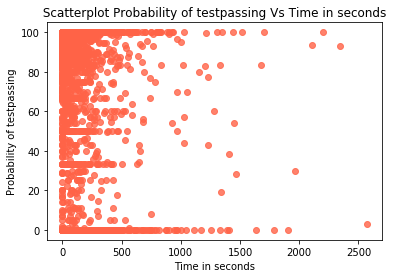

In [28]:
plt.scatter(df_new.time_in_sec, df_new.prob_testsPassed, color='tomato', alpha = 0.8)
plt.title(" Scatterplot Probability of testpassing Vs Time in seconds ")
plt.xlabel('Time in seconds')
plt.ylabel('Probability of testpassing')
plt.show()

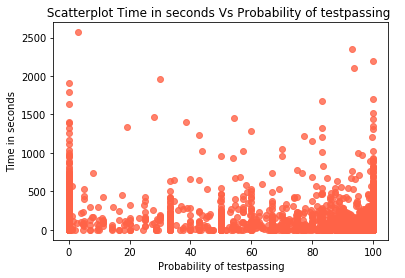

In [29]:
# switched parameters on the axis
plt.scatter(df_new.prob_testsPassed, df_new.time_in_sec, color='tomato', alpha = 0.8)
plt.title(" Scatterplot Time in seconds Vs Probability of testpassing  ")
plt.xlabel('Probability of testpassing')
plt.ylabel('Time in seconds')
plt.show()

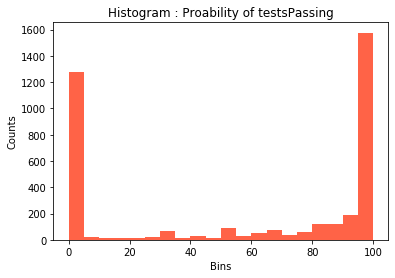

In [30]:
plt.hist(df_new.prob_testsPassed, bins=20, color='tomato')
plt.title('Histogram : Proability of testsPassing')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.show()

In [31]:
# get entries of testPassing that are fully completed (100%) within 10 minutes 
ten = df_new.loc[((df_new.time_in_sec <= 600 ) & (df_new.prob_testsPassed == 100)),:]

In [32]:
# get entries of testPassing that are not fully completed within 10 minutes 
Nten = df_new.loc[((df_new.time_in_sec <= 600 ) & (df_new.prob_testsPassed < 100)),:] 

In [33]:
# get entries over ten minutes of testPassing that are either fully completed or not within 10 minutes 
Oten = df_new.loc[((df_new.time_in_sec > 600 ) & (df_new.prob_testsPassed <= 100)),:] 

In [34]:
print(len(ten)/len(df_new) * 100) # % fully completed in 10 minutes or less
print(len(Nten)/len(df_new) * 100) # % not fully completed in 10 minutes or less
print(len(Oten)/len(df_new) * 100) # % Over 10 minutes, either fully completed or not

34.35294117647059
62.87581699346405
2.7712418300653594


# Machine Learning Alogrithm

In [35]:
# Machine Learning Alogrithm
def MLRegressor(x,y):
    classifiers = [("KNN", KNeighborsRegressor(3)),
                   ("DecisionTree", DecisionTreeRegressor(max_depth=5)),
                   ("SVM_RBF", SVR(kernel='rbf', C=1, gamma=0.1, epsilon=.1))]
    for name,model in classifiers:
        Acc = []
        MSE = []
        RMSE = []
        kf = sklearn.model_selection.KFold(n_splits = 5, shuffle = True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            Acc.append(r2_score(y_test, model.predict(x_test)))
            MSE.append(mean_squared_error(y_test, model.predict(x_test)))
            RMSE.append(np.sqrt(mean_squared_error(y_test, model.predict(x_test))))
            
        print("The model performance for ",name)
        print("-------------------------------------------")
        print("R-Squared Score for ", name, "is", np.mean(Acc))
        print("MSE Value for ", name, "is", np.mean(MSE))
        print("RMSE Value for ", name, "is", np.mean(RMSE))
        print("\n")

In [36]:
x = df_new[["time_in_sec"]]
y = df_new["prob_testsPassed"]
MLRegressor(x,y)

The model performance for  KNN
-------------------------------------------
R-Squared Score for  KNN is -0.2990020598652837
MSE Value for  KNN is 2599.0986761426616
RMSE Value for  KNN is 50.95679704638575


The model performance for  DecisionTree
-------------------------------------------
R-Squared Score for  DecisionTree is -0.004292494291876614
MSE Value for  DecisionTree is 2010.23757906381
RMSE Value for  DecisionTree is 44.83478955934164


The model performance for  SVM_RBF
-------------------------------------------
R-Squared Score for  SVM_RBF is -0.3249111781846403
MSE Value for  SVM_RBF is 2650.687565924165
RMSE Value for  SVM_RBF is 51.45574206521552




<h3> A machine Learning alogrithm to predict events that are fully completed or not

In [39]:
# First, create the label column named "class"
df_new.loc[(df_new.prob_testsPassed == 100), 'class'] = 1 # fully completed
df_new.loc[(df_new.prob_testsPassed < 100), 'class'] = 0 # not fully completed

In [42]:
def MLClassifier(x,y):
    classifiers = [("KNN", KNeighborsClassifier(5)),
                   ("DecisionTree", DecisionTreeClassifier(max_depth=5)),
                   ("Logistic", LogisticRegression()),
                   ("Linear", SGDClassifier())]
    for name,model in classifiers:
        Acc = []
        kf = sklearn.model_selection.KFold(n_splits = 5, shuffle = True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            Acc.append(accuracy_score(y_test, model.predict(x_test), normalize = True))

        print("Accuracy Score for ", name, "is", np.mean(Acc))
        print("-------------------------------------------")

In [43]:
x = df_new[["time_in_sec"]]
y = df_new["class"]
MLClassifier(x,y)

Accuracy Score for  KNN is 0.5916339869281046
-------------------------------------------
Accuracy Score for  DecisionTree is 0.6483660130718955
-------------------------------------------
Accuracy Score for  Logistic is 0.6496732026143791
-------------------------------------------
Accuracy Score for  Linear is 0.5304575163398693
-------------------------------------------
